In [203]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from scipy.spatial import distance

from scipy.stats import norm

from pylab import rcParams
import sklearn 

In [204]:
pd.options.mode.chained_assignment = None  # default='warn'

In [205]:
pathExcel="rK3g26ERseWlQI7rj1yw_Table_1.xlsx"

In [206]:
min_threshold=0.025

In [207]:
def readExcel(pathExcel):
    df=pd.read_excel(pathExcel)
    max_value = df['Pow'].max()
    min_value = df['Pow'].min()
    pos=df.shape[1]
    #Insert the new column normalized power(%)
    df.insert(pos, "NPow", (df.Pow-min_value)/(max_value-min_value), True)
    df.insert(pos+1, "NPow(%)", 100*df.NPow, True)
    return df

In [208]:
def dataPreProcessing1(df):
    #Data points where maximum wind speed has reached more than 25 m/s are also filtered out
    if df['Ws'].max()>25:
        df=df[df['Ws']<=25]
    #samples with missing values or no power production are filtered out
    df1=df.dropna()
    #a lower limit of output power is set at 0 kW for data sample selection.
    df2= df1[df1['Pow'] >= 10]  
    #Time_stamp column not used
    df3=df2[['date_num', 'Ws', 'Pow', 'Temp', 'Pressure', 'NPow','NPow(%)']]
    return df3

In [209]:
def is_pos_def(A):
    '''define if the matrix is positive definite'''
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False



In [210]:
def MahalanobisDist(data,verbose=False):
    '''calculates Mahalanobis distance from the mean value'''
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("2 Error: Inverse of Covariance Matrix is not positive definite!")
            return md
    else:
        print("1 Error: Covariance Matrix is not positive definite!")
        return md

In [211]:
def insertColumns(result,data,pos):
    ''' Insert inside the dataframe the distance calculated and the probability density'''
    data.insert(pos, "dist", result, True)
    num_tot=data['date_num'].sum()
    data.insert(pos+1,'Pd(%)',((data['dist']*data['date_num']*100)/num_tot), True)
    return data

In [212]:
def dataPreProcessing2(df):
    pd_list=[]
    list_df=[]
    try:
        if df.shape[0]>0:
            data=df[(df['Temp']>=0)]
            data1=data[['Ws','Temp']]
            list_df=data1.to_numpy()
            #print(len(list_df))
            if len(list_df)>0:
                result=MahalanobisDist(list_df,verbose=False)
            #print(len(result))
                if len(result)>0:
                    pos=list_df.shape[1]
                    data=insertColumns(result,data,pos)
                #print(data.shape[0])
                    pd_list.append(data)
                return pd_list
        else:
            return df4.shape[0]
    except:
        print('error')
        return len(list_df)

In [213]:
def dataPreProcessing3(df):
    pd_list_l=[]
    list_df=[]
    try:
        if df.shape[0]>0:
            data=df[(df['Temp']<0)]
            data1=data[['Ws','Temp']]

            list_df=data1.to_numpy()
            if len(list_df)>0:
                result=MahalanobisDist(list_df,verbose=False)
                if len(result)>0:
                    pos=list_df.shape[1]
                    data=insertColumns(result,data,pos)
                    #print(data.shape[0])
                    pd_list_l.append(data)
                return pd_list_l
        else:
            return df.shape[0]
            
    except:
        print('error')
        return len(list_df)


In [214]:
def plotCurves(df,df1):
    ax=df.plot(kind='scatter',x='Ws',y='NPow(%)',color='red')
    df1.plot(ax=ax, kind='scatter',x='Ws',y='NPow(%)',color='blue')
    ax.set_xlabel("Ws(m/s)")
    ax.set_ylabel("NPow(%)")
    plt.show()

In [215]:
def plotHist(df):
    #Figure 1 of the paper
    plt.hist(df.dist,bins=20,rwidth=0.8, density=True)
    plt.xlabel('Mahalanobis distance values of data vectors from its cluster centre')
    plt.ylabel('Probability density')
    rng=np.arange(df.dist.min(),df.dist.max(),0.1)
    plt.plot(rng,norm.pdf(rng,df.dist.mean(),df.dist.std()))

In [216]:
def outliersRemoval(df_end3):
    #outliers removal
    df_end4=df_end3[(df_end3['NPow(%)']<27)&(df_end3['Ws']>7)]
    if df_end4.shape[0]>0:
        con1=(df_end3['NPow(%)']<27)&(df_end3['Ws']>7)
        df_end5=df_end3[~(con1)]
        con2=(df_end3['NPow(%)']>20)&(df_end3['NPow(%)']<80)&(df_end3['Ws']>11)
        df_end6=df_end3[~(con2)]
        con3=(df_end6['NPow(%)']<27)&(df_end6['Ws']>7)
        df_end7=df_end6[~(con3)]
        return df_end7

In [217]:
def DataPreprocessing(pathExcel):
    try:
        df_new11=readExcel(pathExcel)
        if df_new11.shape[0]>0:
            df3=dataPreProcessing1(df_new11)
            dfEnd1=dataPreProcessing2(df3)
            dfEnd2=dataPreProcessing3(df3)
            #T>0
            df_end=pd.concat(dfEnd1)
            #T<0
            df_end1=pd.concat(dfEnd2)
            #Concatenate all the dataframes with T>0 and T<0 
            df_endTOT=pd.concat([df_end,df_end1])
            #Plot Hist
            print(plotHist(df_endTOT))
            #>min_threshold
            if df_endTOT.shape[0]>0:
                df_endTOTMin=df_endTOT[df_endTOT['Pd(%)']>min_threshold]
                #cut outliers manually
                df_new_out=outliersRemoval(df_endTOTMin)
                #old and new curve
                print(plotCurves(df_new11,df_new_out))
        else:
            print("empty df")
    except:
        print("Error")

None


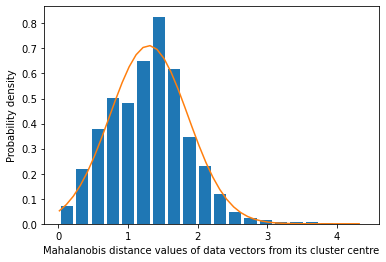

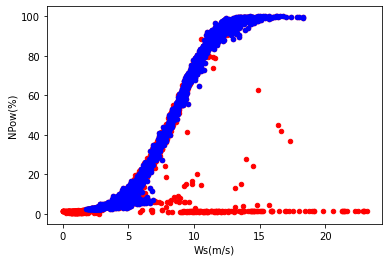

None


In [218]:
DataPreprocessing(pathExcel)